In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import torchvision
import tarfile
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
project_name='cifar-10-better-techniques'

# Extracting the Dataset

In [3]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url,'.')

In [4]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))

['labels.txt', 'test', 'train']


In [6]:
train_dir=data_dir+'/train'
test_dir=data_dir+'/test'
classes=os.listdir(train_dir)

In [7]:
classes.sort()
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Image Augmentation

This needs to be done to make our model better at generaliztion and not overfit on the data that it is training on. We can add some noise to data like rotations, smoothening, flipping, moving etc. to add some variation in the dataset which will not change the label of the original image but instead some of them will change the location of the same object which will help the model to also detect the object in different locations and different orientations rather than just detecting the object as it is in the images in the training set

We will also be performing channel wise normalization of the data because the values for the pixels in each of the channels can vary a lot and to get them into a constrained range whose standard deviation is 1 and mean is 0 will help us to remove any disproportionality of one of the channels affecting the gradients a lot more than the other channels. For example, the values in the blue channel might range from 0 to 255 but in the red channel the pixel values might only be between 0 to 50 and hence blue channle pixel values will start dominating and to prevent it we use normalization

In [8]:
stats=((0.4914,0.4822,0.4465),(0.2023, 0.1994, 0.2010)) # 0.2470,0.2434,0.2614
# now applying the transforms which we need
train_tms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                     tt.RandomHorizontalFlip(),
                     tt.ToTensor(),
                     tt.Normalize(*stats,inplace=True)])
valid_tms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats,inplace=True)])

In [9]:
train_ds=ImageFolder(train_dir,train_tms)
valid_ds=ImageFolder(test_dir,valid_tms)

now we will have to make data loaders which will help feed in the training data to the model in batches of images

In [34]:
batch_size=256
train_d=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_d=DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=True)
len(train_d)

196

In [12]:
def show(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(20,16))
        ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
        break

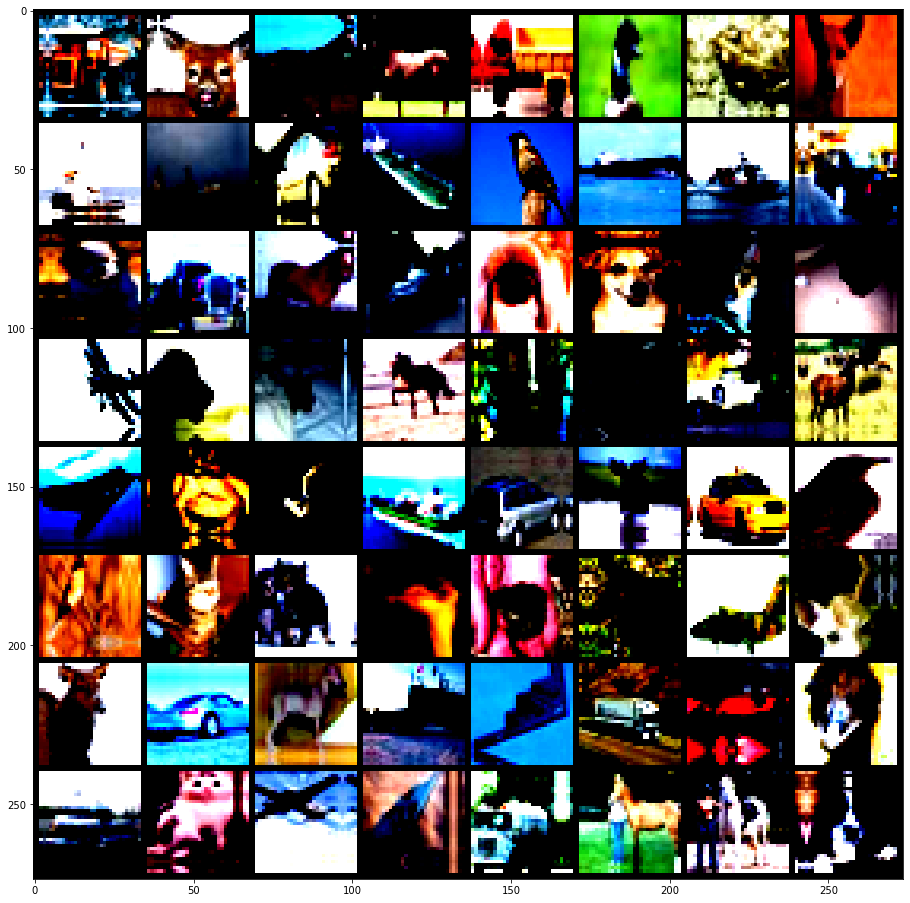

In [13]:
show(train_d)

You can see that the colors in the images have changed and have become more vibrant, this is because of the normalization which we have done and also we can see the results of the augmentations which we performed

# Getting the GPU

In [14]:
def get_default_device():
    '''picks the GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return[to_device(x,device) for x in data]
    return data.to(device,non_blocking =True)

class DeviceDataLoader():
    
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl) # Number of Batches

In [15]:
device=get_default_device()
device

device(type='cuda')

In [35]:
train_dl=DeviceDataLoader(train_d,device)
valid_dl=DeviceDataLoader(val_d,device)

# Making the Resenet model

In [36]:
def accuracy(outputs,label):
    _,pred=torch.max(outputs,axis=1)
    return torch.tensor(torch.sum(pred==label).item()/len(label))

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
    def val_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss.detach(),'val_acc':acc}
    def val_end_step(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        batch_accs=[x['val_acc'] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()
        epoch_acc=torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    def epoch_end(self,epochs,outputs):
        print("Epoch[{}], last lr:{:.5f}, train_loss:{:.4f}, val_loss:{:.4f}, val_acc:{:.2f}".format(epochs,outputs['lrs'][-1],
        outputs['train_loss'], outputs['val_loss'], outputs['val_acc']))

# Architecture

In [37]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.fcc=nn.Sequential(nn.MaxPool2d(4),
                              nn.Flatten(),
                              nn.Linear(512,128),
                              nn.Linear(128,num_classes))
    def forward(self,batches):
        out=self.conv1(batches)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.fcc(out)
        return(out)

In [38]:
model=to_device(Resnet9(3,10),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Now we will Train the model

In [20]:
@torch.no_grad()

def evaluate(model,val_loader):
    model.eval()
    out=[model.val_step(xb) for xb in val_loader]
    return model.val_end_step(out)
def get_lr(optimizer):
    for pg in optimizer.param_groups:
        return pg['lr']

def fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history=[]
    
    optim=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    
    # lr scheduler
    sched=torch.optim.lr_scheduler.OneCycleLR(optim,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train() # to activate dropout and other things during the training process
        train_losses=[]
        lrs=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optim.step()
            optim.zero_grad()
            
            lrs.append(get_lr(optim))
            sched.step()
        # Validation Phase
        result=evaluate(model,val_dl)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [27]:
history=[evaluate(model,valid_dl)]
history

[{'val_loss': 2.3023905754089355, 'val_acc': 0.10730768740177155}]

In [39]:
%%time
epoch=8
max_lr=0.01
grad_clip=0.1
weight_decay=1e-6
opt=torch.optim.Adam
history+=fit_one_cycle(epoch,max_lr,model,train_dl,valid_dl,weight_decay=weight_decay,grad_clip=grad_clip)

Epoch[0], last lr:0.00394, train_loss:1.3204, val_loss:1.3732, val_acc:0.58
Epoch[1], last lr:0.00935, train_loss:0.9667, val_loss:1.4588, val_acc:0.57
Epoch[2], last lr:0.00972, train_loss:0.7300, val_loss:0.6843, val_acc:0.77
Epoch[3], last lr:0.00812, train_loss:0.5413, val_loss:0.6423, val_acc:0.80
Epoch[4], last lr:0.00556, train_loss:0.4168, val_loss:0.5173, val_acc:0.83
Epoch[5], last lr:0.00283, train_loss:0.3135, val_loss:0.3712, val_acc:0.88
Epoch[6], last lr:0.00077, train_loss:0.2281, val_loss:0.2906, val_acc:0.90
Epoch[7], last lr:0.00000, train_loss:0.1743, val_loss:0.2793, val_acc:0.91
CPU times: user 38.1 s, sys: 8.24 s, total: 46.3 s
Wall time: 4min 1s


In [45]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sahaajchawla/cifar-10-better-techniques


<IPython.core.display.Javascript object>

In [30]:
history

[{'val_loss': 2.3023905754089355, 'val_acc': 0.10730768740177155},
 {'val_loss': 3.1469736099243164,
  'val_acc': 0.252692312002182,
  'train_loss': 2.3672571182250977,
  'lrs': [0.0040000000000000036,
   0.004001693422122726,
   0.004006773569004279,
   0.004015240082193283,
   0.004027092364298865,
   0.004042329579032861,
   0.004060950651268713,
   0.004082954267117467,
   0.004108338874020345,
   0.004137102680858415,
   0.004169243658078886,
   0.004204759537838346,
   0.004243647814162768,
   0.00428590574312436,
   0.004331530343035128,
   0.004380518394657265,
   0.004432866441430372,
   0.004488570789715235,
   0.004547627509054533,
   0.004610032432450173,
   0.004675781156657205,
   0.0047448690424946455,
   0.004817291215172714,
   0.004893042564636879,
   0.004972117745928331,
   0.005054511179561197,
   0.0051402170519161405,
   0.005229229315650702,
   0.005321541690125789,
   0.005417147661849073,
   0.005516040484934384,
   0.005618213181577791,
   0.00572365854254994

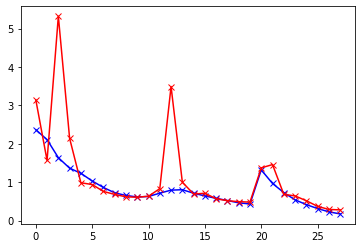

In [40]:
hist=history[1:]
t_l=[x['train_loss'] for x in hist]
v_l=[x['val_loss'] for x in hist]
plt.plot(t_l,'-bx')
plt.plot(v_l,'-rx')
plt.show()

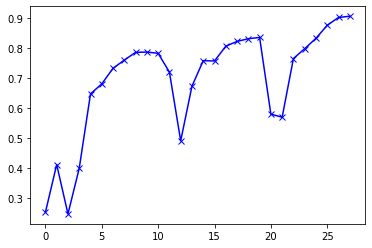

In [41]:
t=[x['val_acc'] for x in hist]
plt.plot(t,'-bx')

In [42]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

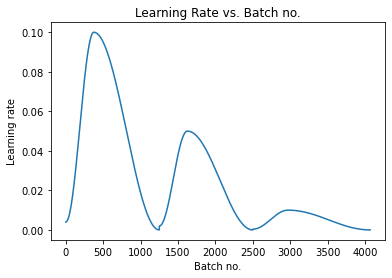

In [44]:
plot_lrs(hist)